<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C5/C5.html"><img src="../data/C5_nav.png" width="100"  style="float:right;" alt="C5"></a>
<h1>Template-Based Chord Recognition</h1> 
</div>

<br/>

<p>
Following Section 5.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook a basic approach for chord recognition using chord templates. For a discussion of the importance of various algorithmic components of such a system, we refer to the following two studies:

<ul>
    
<li><span style="color:black">
Taemin Cho, Juan Pablo Bello: <strong>On the Relative Importance of Individual Components of Chord Recognition Systems.</strong> IEEE/ACM Transactions on Audio, Speech, and Language Processing, 22 (2014), pp. 466&ndash;492. 
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_ChoB14_Chord_IEEE-TASLP.txt"> Bibtex </a>
</span></li>

<li><span style="color:black">
Nanzhu Jiang, Peter Grosche, Verena Konz, Meinard Müller: <strong>Analyzing Chroma Feature Types for Automated Chord Recognition.</strong> Proceedings of the AES Conference on Semantic Audio, Ilmenau, Germany, 2011. 
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_JiangGKM11_Chord_AES.txt"> Bibtex </a>
</span></li>

</ul>   
</p> 

## Introduction

In music, **harmony** refers to the simultaneous sound of different notes that form a cohesive entity in the mind of the listener. The main constituent components of harmony, at least in the Western music tradition, are [**chords**](../C5/C5S1_Chords.html), which are musical constructs
that typically consist of three or more notes. Harmony analysis may be thought of as the study of the construction, interaction, and progression of chords. In this notebook, we discuss a subproblem of harmonic analysis referred to as **chord recognition**, where we consider only a small number of the most important chords as occurring in Western music. Furthermore, we assume that the piece of music is given in the form of an **audio recording**. The resulting chord recognition task consists in splitting up the recording into **segments** and assigning a **chord label** to each segment. The segmentation specifies the start and end time of a chord, and the chord label specifies which chord is played during this time period. A typical chord recognition system consists of **two main steps**. 

* In the first step, the given audio recording is cut into frames, and each frame is transformed into an appropriate **feature vector**. Most recognition systems rely on [**chroma-based audio features**](../C3/C3S1_SpecLogFreq-Chromagram.html), which correlate to the underlying tonal information contained in the audio signal. 
* In the second step, **pattern matching** techniques are used to map each feature vector to a set of predefined **chord models**. The best fit determines the chord label assigned to the given frame. 

To improve the chord recognition results, additional enhancement techniques are applied either before the pattern matching step (referred to as [**prefiltering**](../C5/C5S3_ChordRec_HMM.html)) or after/within the pattern matching step 
(referred to as [**postfiltering**](../C5/C5S3_ChordRec_HMM.html)). In this notebook, we introduce a first chord recognition procedure that employs a simple template-based matching strategy.

<img src="../data/C5/FMP_C5_F13.png" width="500px" align="middle" alt="FMP_C5_F13">

## Beatles Example

In the following example, the chord recognition task is illustrated by the first measures of the Beatles song "Let It Be." The figure shows a score representation, the recording's waveform, a [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html), as well as chord annotations generated in a manual process. 

<img src="../data/C5/FMP_C5_F01.png" width="400px" align="left" alt="FMP_C5_F01">

<br clear="all" />

<audio style="width: 400px;" src="../data/C5/FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.mp3" type="audio/mpeg" controls="controls"></audio>

## Chroma-Based Feature Representation

Given an audio recording of a piece of music, the first step is to transform the recording into a sequence $X=(x_1,x_2,\ldots,x_N)$ of feature vectors $x_n\in\mathcal{F}$, $n\in[1:N]$, where $\mathcal{F}$ denotes a suitable feature space. As mentioned above, nearly all traditional chord recognition procedures rely on some type of [**chroma-based feature representation**](../C3/C3S1_SpecLogFreq-Chromagram.html). This is because chroma-based features capture a signal's short-time tonal content, which is closely correlated to the harmonic progression of the underlying piece. Assuming the [equal-tempered scale](../C1/C1S1_MusicalNotesPitches.html), the chroma values correspond to the set $\{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\ldots,\mathrm{B}\}$, which we identify with the set $[0:11]$. A chroma feature can then be expressed as a $12$-dimensional vector 

$$
x=(x(0),x(1),\ldots,x(11))^\top\in\mathcal{F}=\mathbb{R}^{12}
$$ 

As we also discuss in other FMP notebooks (e.g., in the context of [music synchronization](../C3/C3S1_SpecLogFreq-Chromagram.html) or [content-based music retrieval](../C7/C7S2_CENS.html)), there are many different ways of computing chroma features. Furthermore, their properties can be adjusted by applying suitable postprocessing steps such as [logarithmic compression](../C3/C3S1_LogCompression.html), [normalization](../C3/C3S1_FeatureNormalization.html), or [smoothing](../C3/C3S1_FeatureSmoothing.html). To give some example, we compute in the following code cell three different chroma variants: 

* STFT-based chroma features (`librosa.feature.chroma_stft`). 
* Filter-bank decomposition using IIR elliptic filters (`librosa.iirt`), logarithmic compression, and chroma binning.
* CQT-based chroma features (`librosa.feature.chroma_cqt`)

For each variant, we use the same window length (`N=4096`) and hop size (`H=2048`). Furthermore, in each variant, we normalize the chroma vectors with respect to the [Euclidean norm](../C3/C3S1_FeatureNormalization.html) ($\ell^2$-norm). In the following figure, the resulting chromagrams are visually superimposed with the manually generated chord annotations (in color). 

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa

import sys
sys.path.append('..')
import LibFMP.B
import LibFMP.C3
import LibFMP.C4
%matplotlib inline

def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        fn_wav: Filenname of WAV
        Fs: Sampling rate
        N: Window size
        H: Hop size
        gamma: Constant for logarithmic compression
        version: Technique used for front-end decomposition ('STFT', 'IIS', 'CQT')
        norm: If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')

    Returns:
        X: Chromagram
        Fs_X: Feature reate of chromagram
        x: Audio signal
        Fs: Sampling rate of audio signal
        x_dur: Duration (seconds) of audio signal
    """
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)        
    if norm is not None:
        X = LibFMP.C3.normalize_feature_sequence(X, norm='2')
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur

def plot_chromagram_annotation(ax, X, Fs_X, ann, color_ann, x_dur, cmap='gray_r', title=''):
    """Plot chromagram and annotation
    Notebook: C5/C5S2_ChordRec_Templates.ipynb
    """
    LibFMP.B.plot_chromagram(X, Fs=Fs_X, ax=ax,
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True)
    LibFMP.B.plot_segments_overlay(ann, ax=ax[0], time_max=x_dur,
                                   print_labels=False, colors=color_ann, alpha=0.1)

# Compute chroma features
fn_wav = os.path.join('..', 'data', 'C5', 'Wherever-you-will-go.wav')
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
X_IIR, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X_CQT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

# Annotations
fn_ann = os.path.join('..', 'data', 'C5', 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')
ann, _ = LibFMP.C4.read_structure_annotation(fn_ann)
color_ann = {'N': [1, 1, 1, 1], 'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
             'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1]}

# Plot
cmap = LibFMP.B.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 2, 2, 0.5]}, figsize=(7, 8))
LibFMP.B.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')
LibFMP.B.plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)
ax[0,1].axis('off')

title = 'STFT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_STFT.shape[1])
plot_chromagram_annotation([ax[1, 0], ax[1, 1]], X_STFT, Fs_X, ann, color_ann, x_dur, title=title)

title = 'IIR-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_IIR.shape[1])
plot_chromagram_annotation([ax[2, 0], ax[2, 1]], X_IIR, Fs_X, ann, color_ann, x_dur, title=title)

title = 'CQT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT.shape[1])
plot_chromagram_annotation([ax[3, 0], ax[3, 1]], X_CQT, Fs_X, ann, color_ann, x_dur, title=title)

LibFMP.B.plot_segments(ann, ax=ax[4, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[4,1].axis('off')
plt.tight_layout()

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method

## Template-Based Pattern Matching

Given the chroma sequence $X=(x_1,x_2,\ldots,x_N)$ and a set $\Lambda$ of possible chord labels, the objective of the next step is to map each chroma vector $x_n\in\mathbb{R}^{12}$ to a chord label $\lambda_{n} \in \Lambda$, $n\in[1:N]$. For example, one may consider the set

\begin{equation}
  \Lambda = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{C^\sharp m},\ldots,\mathbf{Bm}\}
\end{equation}

consisting of the [twelve major and twelve minor triads](../C5/C5S1_Chords.html). In this case, each frame $n\in[1:N]$ is assigned to a [major chord](../C5/C5S1_Chords.html) or a [minor chord](../C5/C5S1_Chords.html) specified by $\lambda_{n}$. For the pattern matching step, we now introduce a simple template-based approach. The idea is to precompute a set 

$$
\mathcal{T}\subset\mathcal{F}=\mathbb{R}^{12}
$$ 

of templates denoted by $\mathbf{t}_\lambda\in\mathcal{T}$, $\lambda\in\Lambda$. Intuitively, each template can be thought of as a prototypical chroma vector that represents a specific musical chord. Furthermore, we fix a similarity measure 

\begin{equation}
s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}
\end{equation}

that allows for comparing different chroma vectors. Then, the template-based procedure consists in assigning the chord label that maximizes the similarity between the corresponding template and the given feature vector $x_n$:

\begin{equation}
        \lambda_{n} := \underset{\lambda \in \Lambda}{\mathrm{argmax}}
         \,\, s( \mathbf{t}_\lambda , x_n ).
\end{equation}

In this procedure, there are many design choices that crucially influence the performance of a chord recognizer. 

* Which chords should be considered in $\mathcal{T}$? 
* How are the chord templates defined?  
* What is a suitable similarity measure to compare the feature vectors with the chord templates? 

To obtain a first simple chord recognition system, we make the following design choices. For the chord label set $\Lambda$, we choose the twelve major and twelve minor triads. This choice, even though problematic from a musical point of view, is convenient and instructive. Considering chords up to enharmonic equivalence and up to octave shifts, each triad can be encoded by a three-element subset of $[0:11]$. For example, the $\mathrm{C}$ major chord $\mathbf{C}$ corresponds to the subset $\{0,4,7\}$. Each subset, in turn, can be identified with a binary twelve-dimensional chroma vector $x=(x(0),x(1),\ldots,x(11))^\top$, where $x(i)=1$ if and only if the chroma value $i\in[0:11]$ is contained in the chord. For example, in the case of the $\mathrm{C}$-major chord $\mathbf{C}$, the resulting chroma vector is

\begin{equation}
\label{eq:ChordReco:Template:Basic:ChromaVectC}
    \mathbf{t}_{\mathbf{C}}{} := x =(1,0,0,0,1,0,0,1,0,0,0,0)^\top.
\end{equation}

Using a chroma-based encoding, the twelve major chords and twelve minor chords can be obtained by [cyclically shifting](../C3/C3S1_TranspositionTuning.html) the binary vectors for the $\mathrm{C}$-major and the $\mathrm{C}$-minor triads, respectively. The result is illustrated by the following figure.

<img src="../data/C5/FMP_C5_F06.png" width="700px" align="middle" alt="FMP_C5_F06">

For comparing chroma features and chord templates, we use in the following a simple similarity measure using the inner product of normalized vectors:

\begin{equation}
  s(x,y)= \frac{\langle x,y\rangle}{\|x\|\cdot\|y\|}
\end{equation}

for $x,y\in\mathcal{F}$ with  $\|x\|\not= 0$ and $\|y\|\not= 0$. In the case $\|x\|=0$ or $\|y\|=0$, we set $s(x,y)=0$. Note that this measure always yields a value $s(x,y)\in[-1,1]$. In the case that the vectors $x$ and $y$ only have positive entries, one has $s(x,y)\in[0,1]$.

## Implementation

In the following code cell, we provide an implementation for the template-based chord recognition procedure described before. To obtain a better understanding of this procedure, we continue our Beatles example from above. The following steps are performed and visualized:

* First, the audio recording is converted into a chroma representation. As an example, we use the STFT-variant as computed before. 

* Second, each chroma vector is compared with each of the $24$ binary chord templates, which yields $24$ similarity values per frame. These similarity values are visualized in the form of a **time&ndash;chord representation**.

* Third, we select for each frame the chord label $\lambda_{n}$ of the template that maximizes the similarity value over all $24$ chord templates. This yields our final chord recognition result, which is shown in the form of a  **binary time&ndash;chord representation**.

* Fourth, the manually generated chord annotations are visualized.

In the following figure, all visualizations are superimposed with the manually generated chord annotations. 

<!--<img src="../data/C5/FMP_C5_F15.png" width="400px" align="middle" alt="FMP_C5_F15">-->

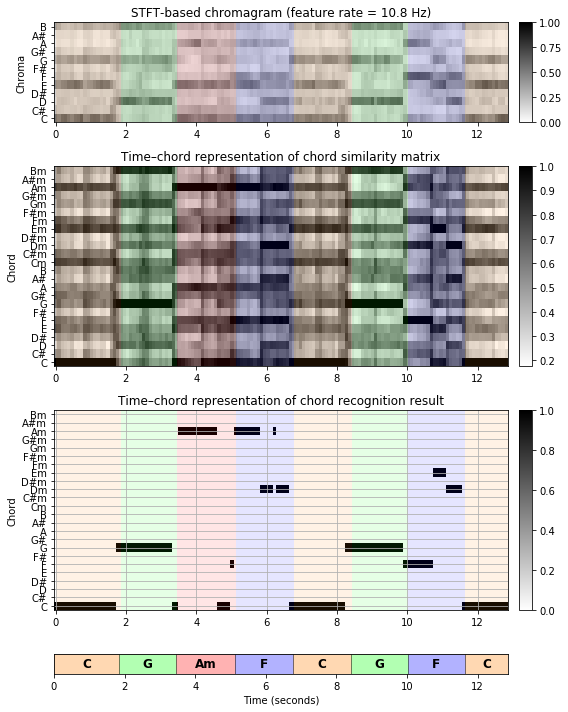

In [2]:
def get_chord_labels(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly non-chord label)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord: If "True" then add nonchord label

    Returns:
        chord_labels: List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord: If "True" then add nonchord template
        
    Returns:
        chord_templates: Matrix containing chord_templates as columns
    """      
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T 
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates

def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X: Chromagram
        norm_sim: Specifies norm used for normalizing chord similarity matrix
        nonchord: If "True" then add nonchord template

    Returns:
        chord_sim: Chord similarity matrix
        chord_max: Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = LibFMP.C3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = LibFMP.C3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = LibFMP.C3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

# Chord recognition
X = X_STFT
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels(nonchord=False)

# Plot
cmap = LibFMP.B.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3, 0.3]}, figsize=(8, 10))
LibFMP.B.plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
LibFMP.B.plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)
LibFMP.B.plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
LibFMP.B.plot_segments_overlay(ann, ax=ax[2, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_segments(ann, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

The chord similarity values shown in the form of a time–chord representation indicate for each chroma vector a kind of likelihood for the $24$ possible chords. For example, this visualization shows that the chroma vectors at the beginning of the Beatles song are most similar to the template for the $\mathrm{C}$ major chord $\mathbf{C}$. Furthermore, there is also a higher degree of similarity to the templates for $\mathbf{C}$, $\mathbf{Em}$, and $\mathbf{Am}$. Comparing the final chord recognition results with the reference annotation, one can observe that the results obtained from the automated procedure agree with the reference labels for most of the frames. We continue with our discussion of the results in the [FMP notebook on chord recognition evaluation](../C5/C5S2_ChordRec_Eval.html), where we also consider further examples.

We close our Beatles example by looking at the similarity-maximizing chord templates for each frame. This yields a time&dash;chroma representation, which can be compared with the original input chromagram. In a way, the sequence of chord templates may be thought of as a musically informed quantization of the input chroma representation.

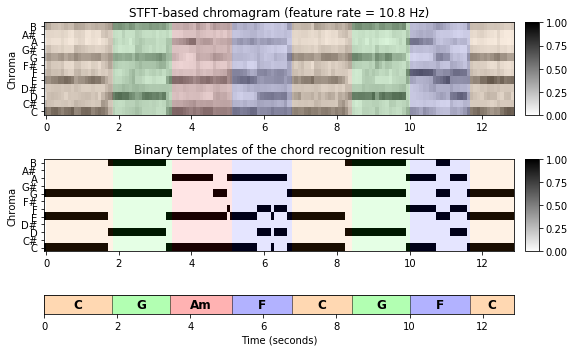

In [3]:
chord_templates = generate_chord_templates() 
X_chord = np.matmul(chord_templates, chord_max)

# Plot
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 1, 0.2]}, figsize=(8, 5))

LibFMP.B.plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
LibFMP.B.plot_segments_overlay(ann, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_chromagram(X_chord, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='Binary templates of the chord recognition result')
LibFMP.B.plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_segments(ann, ax=ax[2, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[2,1].axis('off')
plt.tight_layout()

## Further Notes

In this notebook, we have studied the problem of chord recognition with the objective of automatically extracting chord labels from a given music recording. Only considering the $24$ major and minor triads in a simplistic scenario, we introduced a first template-based matching procedure that compares chroma features of the music recording with prototypical chroma templates of the triads. Already with this simple baseline approach, there are many design choices that have a substantial influence on the final chord recognition results. 

* In this notebook, we have used **idealized binary chord templates** that indicate the presence or absence of notes in the given chord. For real music recordings, however, the presence of [harmonics](../C1/C1S3_HarmonicSeries.html) and other sound components leads to chroma features where the energy is spread over the chroma bands in a more unstructured, non-binary fashion. This motivates the usage of **chord templates with harmonics**, where the chroma patterns also account for the harmonics of the chord notes.

* Instead of explicitly modeling the harmonics, a conceptually different approach is to **learn** chroma patterns from labeled training data. The input of such a **supervised learning** procedure consists of pairs of a chroma vector and a corresponding chord label. A simple way is then to derive chord templates by suitably averaging chroma vectors that are labeled with the same chord. 

* Taking the average templates is a simple way to adapt a template-based chord recognizer to given training data. More involved approaches are often based on statistical models that capture not only the **averages** but also the **variances** in the training data. In such approaches, the templates are replaced by chord models that are specified by, e.g., **Gaussian distributions** given in terms of a mean vector and a covariance matrix. The similarity of a given chroma vector to a chord model is then expressed by a Gaussian probability value and the assigned label is determined by the probability-maximizing chord model. The discussion of such statistical approaches is beyond the scope of these notebooks, and we refer the reader to the overview article by Cho and Bello.

* Besides refining and adapting the chord templates, another general strategy is to modify and enhance the chroma features extracted from the audio recordings to be analyzed. We have already seen at the beginning of this notebook that there are many **chroma variants** with quite different properties. The chroma type used has a strong influence on the chord recognition results, as has been demonstrated by Jiang et al. in their article on **Analyzing Chroma Feature Types for Automated Chord Recognition**.

Some of these components and more elaborate procedures for automated chord recognition are discussed in the subsequent notebooks.

* In the [FMP notebook on chord recognition evaluation](../C5/C5S2_ChordRec_Eval.html), we introduce some evaluation measures and discuss further phenomena and examples.
* In the [FMP notebook on HMM-based chord recognition](../C5/C5S3_ChordRec_HMM.html), we discuss a chord recognition procedure that applies a context-aware postfiltering technique.
* In the [FMP notebook on the Beatles collection](../C5/C5S3_ChordRec_Beatles.html), we present a case study that indicates the relevance of various chord recognition components. 

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and  <a href="https://www.audiolabs-erlangen.de/fau/assistant/weiss">Christof Weiß</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>